In [1]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import os
from Bio import Phylo
import pickle
import arviz as az
from scipy.stats import poisson,mannwhitneyu
from scipy.integrate import solve_ivp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['font.size']=12
plt.rcParams['pdf.fonttype']=42

In [3]:
os.chdir('..')

In [4]:
T=28

/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


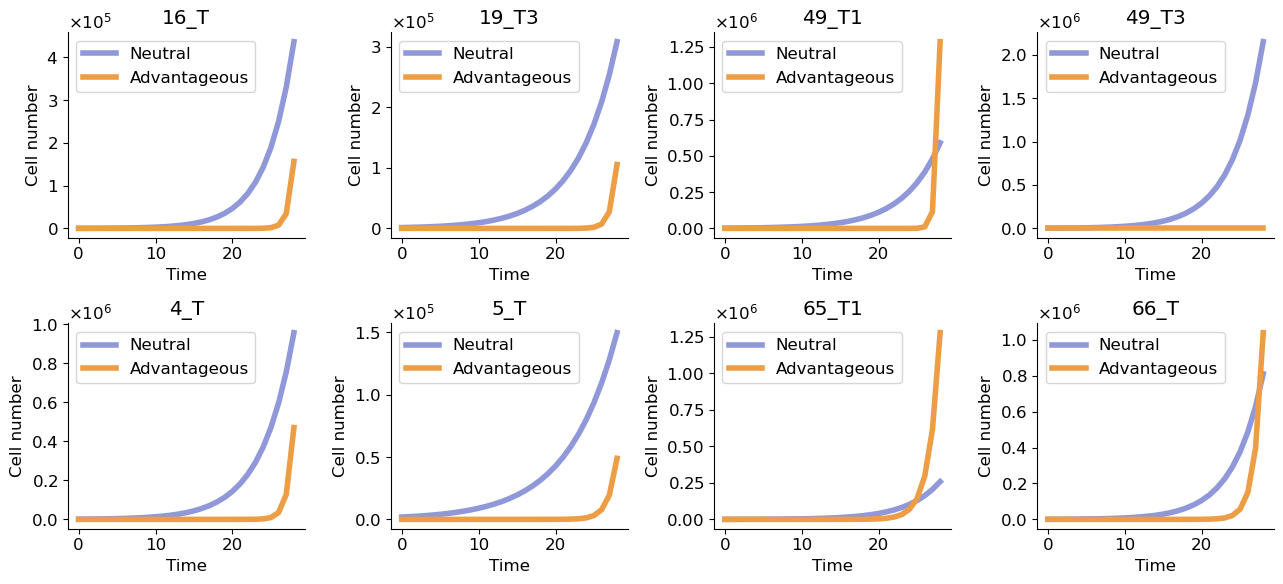

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(13, 6))
for ind, file in enumerate([i for i in os.listdir('./datasets/IBD_tumor') if i[-1]=='z']):
    file = f'./datasets/IBD_tumor/{file}'
    idata = pickle.load(open(f"./results/IBD_tumor/{file.split('/')[-1]}"[:-3], 'rb'))
    de = pickle.load(open(f"./results/IBD_tumor/{file.split('/')[-1][:-3]}_de", 'rb'))
    c0 = de[0][-1][-1]
    theta_h = az.summary(idata).loc['r,a,s,u'.split(',')]['mean'].to_numpy().tolist()
    theta_h = np.array(theta_h)
    theta_h[-1] = float(idata.posterior['u'].mean())
    tree = Phylo.read(file.replace('.phy', '_rescale.nwk')[:-3], format='newick')
    # fig, ax = plt.subplots(figsize=(3.2,3))
    x0 = [c0, 0]
    sol1 = solve_ivp(spx.est_tumor.cellnumber, t_span=(0, T+1), t_eval=range(T+1), y0=x0, 
                    method='RK45', args=theta_h)
    # fig, ax = plt.subplots(1, 2, figsize=(8, 3.2))
    n_nc = sol1.y[0]
    n_ac = sol1.y[1]
    ax[ind//4][ind%4].set_xlabel('Time')
    ax[ind//4][ind%4].set_ylabel('Cell number')
    ax[ind//4][ind%4].plot(sol1.t, n_nc+1, c='#9098d9', lw=4, label='Neutral')
    ax[ind//4][ind%4].plot(sol1.t, n_ac+1, c='#ed9e44', lw=4, label='Advantageous')
    ax[ind//4][ind%4].ticklabel_format (style='sci', scilimits= (-1,2), axis='y',useMathText=True)
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)
    ax[ind//4][ind%4].legend(loc=2)
    ax[ind//4][ind%4].set_title('_'.join(file.split('/')[-1].split('_')[:2]))
plt.tight_layout()

In [5]:
paras = []
for file in [i for i in os.listdir('./datasets/IBD_tumor') if i[-1]=='z']:
    file = f'./datasets/IBD_tumor/{file}'
    idata = pickle.load(open(f"./results/IBD_tumor/{file.split('/')[-1]}"[:-3], 'rb'))
    de = pickle.load(open(f"./results/IBD_tumor/{file.split('/')[-1][:-3]}_de", 'rb'))
    c0 = de[0][-1][-1]
    theta_h = az.summary(idata).loc['r,a,s,u'.split(',')]['mean'].to_numpy().tolist()
    theta_h = np.array(theta_h)
    theta_h[-1] = float(idata.posterior['u'].mean())
    theta_h = list(theta_h)
    
    sol1 = solve_ivp(spx.est_tumor.cellnumber, t_span=(0, T+1), t_eval=range(T+1), y0=[c0, 0], 
                        method='RK45', args=theta_h)
    # fig, ax = plt.subplots(1, 2, figsize=(8, 3.2))
    n_nc = sol1.y[0]
    n_ac = sol1.y[1]
    
    tree = Phylo.read(file.replace('.phy', '_rescale.nwk')[:-3], format='newick')
    theta_h.append(spx.utils.colless_index_corrected(tree))
    theta_h.append(n_ac[-1]/(n_nc[-1]+n_ac[-1]))
    paras.append(theta_h)
paras_df = pd.DataFrame(np.array(paras), columns=['r','a','s','u','colless_index_corrected','adv_frac'], index=['_'.join(i.split('_')[:2]) for i in os.listdir('./datasets/IBD_tumor/') if i[-1]=='z'])

/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0, 0.5, 'Fraction of AC')

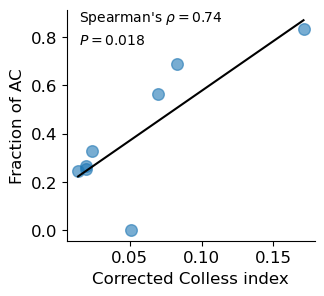

In [7]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(paras_df['colless_index_corrected'], paras_df['adv_frac'], ax=ax, stats='spearmanr', alternative='greater')
ax.set_xlabel("Corrected Colless index")
ax.set_ylabel('Fraction of AC')

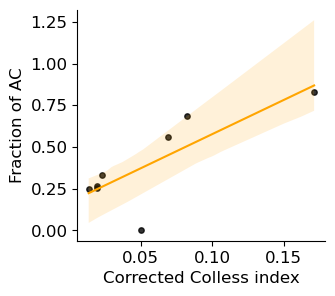

In [ ]:
fig, ax = plt.subplots(figsize=(3.2,3))
# spx.utils.corr_plot(paras_df['colless_index_corrected'], paras_df['adv_frac'], ax=ax, stats='spearmanr', alternative='greater')
sns.regplot(x=paras_df['colless_index_corrected'], y=paras_df['adv_frac'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_xlabel("Corrected Colless index")
ax.set_ylabel('Fraction of AC')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('./results/new/cci_ac.pdf')

Text(0, 0.5, 'Fraction of AC')

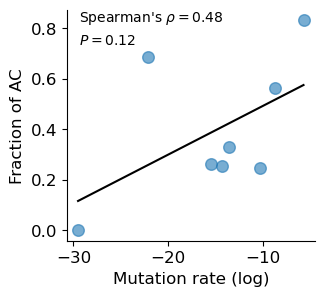

In [8]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(np.log10(paras_df['u']), paras_df['adv_frac'], ax=ax, stats='spearman', alternative='greater')
ax.set_xlabel("Mutation rate (log)")
ax.set_ylabel('Fraction of AC')

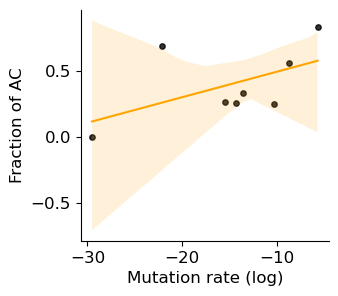

In [ ]:
fig, ax = plt.subplots(figsize=(3.2,3))
# spx.utils.corr_plot(paras_df['colless_index_corrected'], paras_df['adv_frac'], ax=ax, stats='spearmanr', alternative='greater')
sns.regplot(x=np.log10(paras_df['u']), y=paras_df['adv_frac'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_xlabel("Mutation rate (log)")
ax.set_ylabel('Fraction of AC')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('./results/new/mr_ac.pdf')

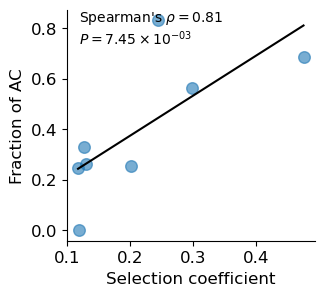

In [59]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(paras_df['s'], paras_df['adv_frac'], ax=ax, stats='spearman',alternative='greater')
ax.set_xlabel("Selection coefficient")
ax.set_ylabel('Fraction of AC')

In [52]:
tumor_size = dict()
tumor_data = spx.data_factory.tumor_data
for i in tumor_data:
    tumor_size[i] = spx.data_factory.cell_number_calc(*tumor_data[i], coef=1)
ts = []
for i in paras_df.index:
    ts.append(tumor_size[i])
paras_df['tumor_size'] = ts

Text(0, 0.5, 'Corrected Colless index')

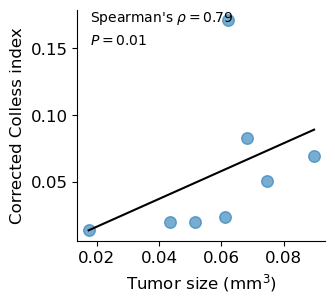

In [ ]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(paras_df['tumor_size'], paras_df['colless_index_corrected'], ax=ax, stats='spearmanr', alternative='greater')
ax.set_xlabel("Tumor size (mm$^3$)")
ax.set_ylabel('Corrected Colless index')

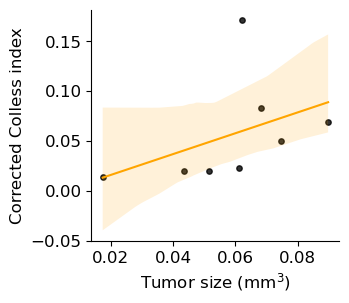

In [ ]:
fig, ax = plt.subplots(figsize=(3.2,3))
# spx.utils.corr_plot(paras_df['colless_index_corrected'], paras_df['adv_frac'], ax=ax, stats='spearmanr', alternative='greater')
sns.regplot(x=paras_df['tumor_size'], y=paras_df['colless_index_corrected'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_xlabel("Tumor size (mm$^3$)")
ax.set_ylabel('Corrected Colless index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('./results/new/ts_cci.pdf')